In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split

from keras.layers import Input, Dense
from keras.models import Model

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray

In [2]:
np.random.seed(1120)

In [3]:
data = pd.read_csv('./data/AT.dat', delimiter="\t",
                   skiprows=[0], names=["k","r","x","A[k,r,x]"])
print(data.head())
data = data.to_numpy()

# Use first 8,056 points as training/validation and rest as test set.
train_data = data[0:8056]
test_data = data[8056:]

       k         r         x  A[k,r,x]
0  0.001  0.010817 -0.973907  1.009217
1  0.001  0.010817 -0.679410  1.009143
2  0.001  0.010817 -0.148874  1.009077
3  0.001  0.010817  0.148874  1.009077
4  0.001  0.010817  0.679410  1.009142


### Implementation
Now, we have a fair understanding of what GA is and how it works. Next, let’s get to coding.

We will use wind power forecast data, which is available at the following link. It consists of normalized (between zero and one) wind power measurements from seven wind farms. To keep things simple, we will use first wind farm data (column named wp1) but I encourage the reader to experiment and extend the code to forecast energy for all seven, wind farms.

Let’s import required packages, load the dataset and define two helper functions. The first method prepare_dataset will segment the data into chunks to create X, Y pair for model training. The X will the wind power values from the past (e.g. 1 to t-1) and Y will be future value at time t. The second method train_evaluate perform three things, 1) decoding GA solution to get window size and number of units. 2) Prepare the dataset using window size found by GA and divide into train and validation set, and 3) train LSTM model, calculate RMSE on validation set and return it as a fitness score of the current GA solution.

In [4]:
data[:,1].shape
data[:,0:3].shape[1]

3

In [5]:
np.zeros(11)[6:11]

array([0., 0., 0., 0., 0.])

In [75]:
def prepare_dataset(data):
    X, Y = np.empty((0)), np.empty((0))
    X = data[:,0:3]
    Y = data[:,3]  
    return X, Y

def train_evaluate(ga_individual_solution):   
    t = time.time()
    
    # Decode GA solution to integer for window_size and num_units
    deep_size_bits = BitArray(ga_individual_solution[0:3])
    num_units_bits = BitArray(ga_individual_solution[3:8])
    learning_rate_bits = BitArray(ga_individual_solution[8:12])
    batch_size_bits = BitArray(ga_individual_solution[12:14])
    epochs_bits = BitArray(ga_individual_solution[14:])
    
    deep_size = 2*deep_size_bits.uint +2
    num_units = 2*num_units_bits.uint +1
    learning_rate = (2*learning_rate_bits.uint+1)*10**(-4)
    batch_size = 2**(batch_size_bits.uint +1)
    epochs = (epochs_bits.uint +1)*50
    
    print('\nDeep Size: ', deep_size, ', Num of Units: ', num_units, ', Learning rate: ', learning_rate)
    print('Batch Size: ', batch_size, ", Num of Epochs: ", epochs)
    
    # Segment the train_data based on new window_size; split into train and validation (80/20)
    X,Y = prepare_dataset(train_data)
    X_train, X_test, y_train, y_test = split(X, Y, test_size = 0.20, random_state = 1120)
    
    # Train LSTM model and predict on validation set
    model = keras.Sequential()
    model.add(keras.Input(shape=(int(X_train.shape[1]),)))
    model.add(layers.Dense(num_units, input_shape=(int(X_train.shape[1]),)))
#     x = LSTM(num_units, input_shape=(window_size,1))(inputs)
    
    for i in range(deep_size):        
        model.add(layers.Dense(num_units, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0,
                                   patience=15,
                                   restore_best_weights=True)]
    model.fit(X_train, y_train, validation_data=(X_test, y_test),
              epochs=epochs, callbacks=callbacks, batch_size=batch_size, shuffle=True)
    y_pred = model.predict(X_test)
    
    # Calculate the RMSE score as fitness score for GA
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print('Validation RMSE: ', rmse)
    print('Time passed: ', time.time()-t)
    
    return rmse,

A continuación, use la paquetería DEAP para definir las cosas para ejecutar GA. Usaremos una representación binaria para la solución de longitud diez. Se inicializará aleatoriamente utilizando la distribución de Bernoulli. Del mismo modo, se utiliza el crossover ordenado, la mutación aleatoria y la selección de la rueda de la ruleta. Los valores del parámetro GA se inicializan arbitrariamente; Te sugerimos que juegues con diferentes configuraciones.



In [76]:
population_size = 10
num_generations = 4
gene_length = 15

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, 
n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, 
                        ngen = num_generations, verbose = True)

C:\Users\Joshu\.conda\envs\tensorflow\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\Joshu\.conda\envs\tensorflow\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)



Deep Size:  6 , Num of Units:  15 , Learning rate:  0.0009000000000000001
Batch Size:  16 , Num of Epochs:  50
Train on 6444 samples, validate on 1612 samples
Epoch 1/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.1860 - val_loss: 0.2187
Epoch 2/50
6444/6444 [==============================] - 3s 487us/sample - loss: 0.1543 - val_loss: 0.0280
Epoch 3/50
6444/6444 [==============================] - 3s 411us/sample - loss: 0.1370 - val_loss: 0.0249
Epoch 4/50
6444/6444 [==============================] - 3s 420us/sample - loss: 0.0333 - val_loss: 0.0046
Epoch 5/50
6444/6444 [==============================] - 3s 539us/sample - loss: 0.4432 - val_loss: 0.4448
Epoch 6/50
6444/6444 [==============================] - 3s 418us/sample - loss: 0.2226 - val_loss: 0.0105
Epoch 7/50
6444/6444 [==============================] - 4s 546us/sample - loss: 0.0081 - val_loss: 0.0042
Epoch 8/50
6444/6444 [==============================] - 3s 485us/sample - loss: 0.0029 - val_loss: 0

6444/6444 [==============================] - 30s 5ms/sample - loss: 2.3172e-04 - val_loss: 2.6762e-04
Epoch 21/50
6444/6444 [==============================] - 30s 5ms/sample - loss: 2.2574e-04 - val_loss: 2.2181e-04
Epoch 22/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 2.2903e-04 - val_loss: 2.4051e-04
Epoch 23/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 2.2451e-04 - val_loss: 2.8270e-04
Epoch 24/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 2.1562e-04 - val_loss: 2.5673e-04
Epoch 25/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 2.1931e-04 - val_loss: 2.2787e-04
Epoch 26/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 2.1447e-04 - val_loss: 2.0490e-04
Epoch 27/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 2.1384e-04 - val_loss: 1.9245e-04
Epoch 28/50
6444/6444 [==============================] - 37s 6ms/sample - loss: 2.1054e-04 - val_los

6444/6444 [==============================] - 15s 2ms/sample - loss: 2.1162e-04 - val_loss: 1.5813e-04
Epoch 41/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 2.1714e-04 - val_loss: 1.7092e-04
Epoch 42/50
6444/6444 [==============================] - 12s 2ms/sample - loss: 2.1390e-04 - val_loss: 1.8152e-04
Epoch 43/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 2.0488e-04 - val_loss: 1.7913e-04
Epoch 44/50
6444/6444 [==============================] - 15s 2ms/sample - loss: 2.0173e-04 - val_loss: 2.3460e-04
Epoch 45/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 2.2473e-04 - val_loss: 2.2530e-04
Epoch 46/50
6444/6444 [==============================] - 16s 2ms/sample - loss: 1.9994e-04 - val_loss: 1.8836e-04
Epoch 47/50
6444/6444 [==============================] - 16s 2ms/sample - loss: 2.0881e-04 - val_loss: 2.3632e-04
Epoch 48/50
6444/6444 [==============================] - 15s 2ms/sample - loss: 2.0401e-04 - val_los

6444/6444 [==============================] - 5s 776us/sample - loss: 3.1083e-04 - val_loss: 2.6521e-04
Epoch 19/100
6444/6444 [==============================] - 5s 784us/sample - loss: 3.2670e-04 - val_loss: 2.9057e-04
Epoch 20/100
6444/6444 [==============================] - 5s 787us/sample - loss: 3.1830e-04 - val_loss: 3.2411e-04
Epoch 21/100
6444/6444 [==============================] - 6s 858us/sample - loss: 0.0082 - val_loss: 4.0100e-04
Epoch 22/100
6444/6444 [==============================] - 5s 766us/sample - loss: 4.2722e-04 - val_loss: 4.0262e-04
Epoch 23/100
6444/6444 [==============================] - 5s 810us/sample - loss: 3.2583e-04 - val_loss: 3.1207e-04
Epoch 24/100
6444/6444 [==============================] - 5s 779us/sample - loss: 2.7945e-04 - val_loss: 2.5690e-04
Epoch 25/100
6444/6444 [==============================] - 6s 866us/sample - loss: 2.7309e-04 - val_loss: 3.4796e-04
Epoch 26/100
6444/6444 [==============================] - 5s 764us/sample - loss: 2.9419e

6444/6444 [==============================] - 30s 5ms/sample - loss: 5.0975e-04 - val_loss: 2.9355e-04
Epoch 6/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 3.6238e-04 - val_loss: 3.1095e-04
Epoch 7/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 3.3444e-04 - val_loss: 2.2906e-04
Epoch 8/100
6444/6444 [==============================] - 31s 5ms/sample - loss: 3.0675e-04 - val_loss: 3.1069e-04
Epoch 9/100
6444/6444 [==============================] - 31s 5ms/sample - loss: 2.8632e-04 - val_loss: 2.2956e-04
Epoch 10/100
6444/6444 [==============================] - 31s 5ms/sample - loss: 2.7246e-04 - val_loss: 2.2244e-04
Epoch 11/100
6444/6444 [==============================] - 31s 5ms/sample - loss: 2.7602e-04 - val_loss: 2.1771e-04
Epoch 12/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.5626e-04 - val_loss: 2.9996e-04
Epoch 13/100
6444/6444 [==============================] - 31s 5ms/sample - loss: 2.4892e-04 - val

Epoch 8/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 0.0019 - val_loss: 2.3322e-04
Epoch 9/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 3.1520e-04 - val_loss: 2.6178e-04
Epoch 10/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.0024 - val_loss: 8.2098e-04
Epoch 11/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 4.1962e-04 - val_loss: 3.6516e-04
Epoch 12/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 2.8971e-04 - val_loss: 2.9990e-04
Epoch 13/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 2.8792e-04 - val_loss: 2.5612e-04
Epoch 14/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 2.9585e-04 - val_loss: 5.2241e-04
Epoch 15/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 2.8655e-04 - val_loss: 2.1743e-04
Epoch 16/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 3.1461e-04 - val_l

6444/6444 [==============================] - 3s 431us/sample - loss: 1.8119e-04 - val_loss: 1.8805e-04
Epoch 29/100
6444/6444 [==============================] - 3s 428us/sample - loss: 1.7646e-04 - val_loss: 1.7900e-04
Epoch 30/100
6444/6444 [==============================] - 3s 429us/sample - loss: 1.7296e-04 - val_loss: 1.7244e-04
Epoch 31/100
6444/6444 [==============================] - 3s 427us/sample - loss: 1.6921e-04 - val_loss: 1.8843e-04
Epoch 32/100
6444/6444 [==============================] - 3s 433us/sample - loss: 2.0105e-04 - val_loss: 1.8531e-04
Epoch 33/100
6444/6444 [==============================] - 3s 428us/sample - loss: 1.9075e-04 - val_loss: 1.8681e-04
Epoch 34/100
6444/6444 [==============================] - 3s 429us/sample - loss: 1.8366e-04 - val_loss: 1.7518e-04
Epoch 35/100
6444/6444 [==============================] - 3s 427us/sample - loss: 1.7816e-04 - val_loss: 1.8631e-04
Epoch 36/100
6444/6444 [==============================] - 3s 429us/sample - loss: 1.8

Epoch 10/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 3.2061e-04 - val_loss: 3.5266e-04
Epoch 11/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 2.8897e-04 - val_loss: 2.4628e-04
Epoch 12/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 3.0690e-04 - val_loss: 5.3807e-04
Epoch 13/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.0208 - val_loss: 3.7967e-04
Epoch 14/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 4.0271e-04 - val_loss: 3.8607e-04
Epoch 15/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 3.3291e-04 - val_loss: 3.0892e-04
Epoch 16/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 3.0690e-04 - val_loss: 3.0061e-04
Epoch 17/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 2.7267e-04 - val_loss: 2.3825e-04
Epoch 18/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 2.6

Epoch 29/50
6444/6444 [==============================] - 4s 555us/sample - loss: 9.3252e-04 - val_loss: 3.0577e-04
Epoch 30/50
6444/6444 [==============================] - 4s 550us/sample - loss: 2.5983e-04 - val_loss: 2.2978e-04
Epoch 31/50
6444/6444 [==============================] - 3s 542us/sample - loss: 2.4861e-04 - val_loss: 2.1960e-04
Epoch 32/50
6444/6444 [==============================] - 4s 559us/sample - loss: 2.4420e-04 - val_loss: 2.5151e-04
Epoch 33/50
6444/6444 [==============================] - 4s 563us/sample - loss: 2.3473e-04 - val_loss: 2.5433e-04
Epoch 34/50
6444/6444 [==============================] - 4s 555us/sample - loss: 2.3276e-04 - val_loss: 2.3114e-04
Epoch 35/50
6444/6444 [==============================] - 4s 558us/sample - loss: 2.3106e-04 - val_loss: 2.1031e-04
Epoch 36/50
6444/6444 [==============================] - 4s 558us/sample - loss: 2.3700e-04 - val_loss: 2.1415e-04
Epoch 37/50
6444/6444 [==============================] - 4s 547us/sample - loss:

Epoch 49/50
6444/6444 [==============================] - 3s 508us/sample - loss: 2.2645e-04 - val_loss: 2.4515e-04
Validation RMSE:  0.014686927400702527
Time passed:  160.49052381515503

Deep Size:  10 , Num of Units:  47 , Learning rate:  0.0021000000000000003
Batch Size:  4 , Num of Epochs:  50
Train on 6444 samples, validate on 1612 samples
Epoch 1/50
6444/6444 [==============================] - 16s 2ms/sample - loss: 0.5451 - val_loss: 0.0287
Epoch 2/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.0330 - val_loss: 5.4289e-04
Epoch 3/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 0.0027 - val_loss: 0.0074
Epoch 4/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 5.3538e-04 - val_loss: 4.0136e-04
Epoch 5/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 8.0845e-04 - val_loss: 4.4002e-04
Epoch 6/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 4.3984e-04 - val_loss: 5.9125

Epoch 19/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.7955e-04 - val_loss: 2.6920e-04
Epoch 20/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.1031e-04 - val_loss: 2.4946e-04
Epoch 21/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.9740e-04 - val_loss: 2.5920e-04
Epoch 22/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.7151e-04 - val_loss: 2.7060e-04
Epoch 23/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.4415e-04 - val_loss: 4.6744e-04
Epoch 24/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.3414e-04 - val_loss: 4.8063e-04
Epoch 25/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 7.8889e-04 - val_loss: 2.8209e-04
Epoch 26/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.1830e-04 - val_loss: 2.8056e-04
Epoch 27/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.7227e-

Epoch 91/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.5759e-04 - val_loss: 1.3944e-04
Epoch 92/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.5640e-04 - val_loss: 2.1883e-04
Epoch 93/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.7238e-04 - val_loss: 1.7813e-04
Epoch 94/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.5643e-04 - val_loss: 1.5273e-04
Epoch 95/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.5028e-04 - val_loss: 1.3395e-04
Epoch 96/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.4968e-04 - val_loss: 1.4186e-04
Epoch 97/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.6001e-04 - val_loss: 1.6540e-04
Epoch 98/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.6492e-04 - val_loss: 1.4475e-04
Epoch 99/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.5169e-

6444/6444 [==============================] - 13s 2ms/sample - loss: 1.8988e-04 - val_loss: 2.1084e-04
Epoch 61/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 1.8059e-04 - val_loss: 1.7924e-04
Epoch 62/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 1.6966e-04 - val_loss: 1.5418e-04
Epoch 63/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 1.7969e-04 - val_loss: 1.8402e-04
Epoch 64/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 1.7868e-04 - val_loss: 1.6767e-04
Epoch 65/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 1.6774e-04 - val_loss: 1.3274e-04
Epoch 66/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 1.6914e-04 - val_loss: 1.7808e-04
Epoch 67/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 1.7985e-04 - val_loss: 2.5518e-04
Epoch 68/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 1.6962e-04 -

Epoch 30/50
6444/6444 [==============================] - 31s 5ms/sample - loss: 2.2583e-04 - val_loss: 5.9216e-04
Epoch 31/50
6444/6444 [==============================] - 30s 5ms/sample - loss: 2.1052e-04 - val_loss: 1.8608e-04
Epoch 32/50
6444/6444 [==============================] - 30s 5ms/sample - loss: 2.0936e-04 - val_loss: 3.3122e-04
Epoch 33/50
6444/6444 [==============================] - 31s 5ms/sample - loss: 2.2068e-04 - val_loss: 1.6208e-04
Epoch 34/50
6444/6444 [==============================] - 30s 5ms/sample - loss: 2.1311e-04 - val_loss: 2.0543e-04
Epoch 35/50
6444/6444 [==============================] - 31s 5ms/sample - loss: 2.1156e-04 - val_loss: 2.5813e-04
Epoch 36/50
6444/6444 [==============================] - 31s 5ms/sample - loss: 2.1113e-04 - val_loss: 1.8381e-04
Epoch 37/50
6444/6444 [==============================] - 31s 5ms/sample - loss: 2.1054e-04 - val_loss: 1.9780e-04
Epoch 38/50
6444/6444 [==============================] - 31s 5ms/sample - loss: 2.1811e-

6444/6444 [==============================] - 31s 5ms/sample - loss: 1.8772e-04 - val_loss: 2.3764e-04
Validation RMSE:  0.015415483452363262
Time passed:  1535.8108849525452

Deep Size:  12 , Num of Units:  63 , Learning rate:  0.00030000000000000003
Batch Size:  4 , Num of Epochs:  50
Train on 6444 samples, validate on 1612 samples
Epoch 1/50
6444/6444 [==============================] - 23s 4ms/sample - loss: 0.2034 - val_loss: 0.0060
Epoch 2/50
6444/6444 [==============================] - 19s 3ms/sample - loss: 0.0052 - val_loss: 0.0069
Epoch 3/50
6444/6444 [==============================] - 21s 3ms/sample - loss: 0.0245 - val_loss: 0.0052
Epoch 4/50
6444/6444 [==============================] - 22s 3ms/sample - loss: 9.4422e-04 - val_loss: 3.7889e-04
Epoch 5/50
6444/6444 [==============================] - 17s 3ms/sample - loss: 4.7760e-04 - val_loss: 3.6105e-04
Epoch 6/50
6444/6444 [==============================] - 16s 3ms/sample - loss: 6.1180e-04 - val_loss: 3.1993e-04
Epoch 7/50


6444/6444 [==============================] - 8s 1ms/sample - loss: 3.7287e-04 - val_loss: 0.0016
Epoch 20/50
6444/6444 [==============================] - 10s 1ms/sample - loss: 0.0033 - val_loss: 0.0042
Epoch 21/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 0.0017 - val_loss: 3.3950e-04
Epoch 22/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 3.4020e-04 - val_loss: 2.8030e-04
Epoch 23/50
6444/6444 [==============================] - 10s 1ms/sample - loss: 3.3595e-04 - val_loss: 4.0714e-04
Epoch 24/50
6444/6444 [==============================] - 10s 1ms/sample - loss: 3.6942e-04 - val_loss: 3.0410e-04
Epoch 25/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 3.5407e-04 - val_loss: 3.4040e-04
Epoch 26/50
6444/6444 [==============================] - 9s 1ms/sample - loss: 3.7325e-04 - val_loss: 2.9387e-04
Epoch 27/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 3.8766e-04 - val_loss: 4.2665e-04
Epoc

6444/6444 [==============================] - 41s 6ms/sample - loss: 2.1008e-04 - val_loss: 2.2257e-04
Epoch 40/50
6444/6444 [==============================] - 44s 7ms/sample - loss: 2.1023e-04 - val_loss: 2.1999e-04
Epoch 41/50
6444/6444 [==============================] - 40s 6ms/sample - loss: 2.0670e-04 - val_loss: 2.5218e-04
Epoch 42/50
6444/6444 [==============================] - 37s 6ms/sample - loss: 2.0710e-04 - val_loss: 2.1533e-04
Epoch 43/50
6444/6444 [==============================] - 36s 6ms/sample - loss: 2.1220e-04 - val_loss: 1.5784e-04
Epoch 44/50
6444/6444 [==============================] - 36s 6ms/sample - loss: 2.0913e-04 - val_loss: 2.4554e-04
Epoch 45/50
6444/6444 [==============================] - 38s 6ms/sample - loss: 2.2455e-04 - val_loss: 2.6760e-04
Epoch 46/50
6444/6444 [==============================] - 45s 7ms/sample - loss: 2.0561e-04 - val_loss: 2.8258e-04
Epoch 47/50
6444/6444 [==============================] - 43s 7ms/sample - loss: 2.2238e-04 - val_los

6444/6444 [==============================] - 31s 5ms/sample - loss: 1.5815e-04 - val_loss: 1.3141e-04
Epoch 62/100
6444/6444 [==============================] - 31s 5ms/sample - loss: 1.5705e-04 - val_loss: 1.1783e-04
Epoch 63/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 1.5998e-04 - val_loss: 1.5303e-04
Epoch 64/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 1.5509e-04 - val_loss: 1.3228e-04
Epoch 65/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 1.5357e-04 - val_loss: 1.5232e-04
Epoch 66/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 1.5281e-04 - val_loss: 1.2400e-04
Epoch 67/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 1.5323e-04 - val_loss: 1.3934e-04
Epoch 68/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 1.5744e-04 - val_loss: 1.2552e-04
Epoch 69/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 1.5398e-04 -

6444/6444 [==============================] - 7s 1ms/sample - loss: 2.9952e-04 - val_loss: 2.2890e-04
Epoch 32/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.7295e-04 - val_loss: 2.3950e-04
Epoch 33/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.3961e-04 - val_loss: 2.1390e-04
Epoch 34/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.2765e-04 - val_loss: 2.3274e-04
Epoch 35/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.1632e-04 - val_loss: 2.1697e-04
Epoch 36/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.1950e-04 - val_loss: 1.9343e-04
Epoch 37/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.2050e-04 - val_loss: 1.9384e-04
Epoch 38/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.0913e-04 - val_loss: 2.2593e-04
Epoch 39/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.1142e-04 - val_loss

6444/6444 [==============================] - 7s 1ms/sample - loss: 0.1323 - val_loss: 0.0054
Epoch 2/100
6444/6444 [==============================] - 4s 596us/sample - loss: 0.0017 - val_loss: 0.0011
Epoch 3/100
6444/6444 [==============================] - 4s 587us/sample - loss: 7.6143e-04 - val_loss: 4.5161e-04
Epoch 4/100
6444/6444 [==============================] - 4s 590us/sample - loss: 4.6678e-04 - val_loss: 4.5861e-04
Epoch 5/100
6444/6444 [==============================] - 4s 593us/sample - loss: 4.0184e-04 - val_loss: 3.4961e-04
Epoch 6/100
6444/6444 [==============================] - 4s 592us/sample - loss: 3.6399e-04 - val_loss: 2.9881e-04
Epoch 7/100
6444/6444 [==============================] - 4s 588us/sample - loss: 3.4612e-04 - val_loss: 2.9648e-04
Epoch 8/100
6444/6444 [==============================] - 4s 586us/sample - loss: 5.9244e-04 - val_loss: 0.0080
Epoch 9/100
6444/6444 [==============================] - 4s 590us/sample - loss: 0.0041 - val_loss: 4.3303e-04
Epo

6444/6444 [==============================] - 32s 5ms/sample - loss: 2.3321e-04 - val_loss: 2.6813e-04
Epoch 25/50
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.3531e-04 - val_loss: 3.0471e-04
Epoch 26/50
6444/6444 [==============================] - 31s 5ms/sample - loss: 2.3227e-04 - val_loss: 2.2712e-04
Epoch 27/50
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.2171e-04 - val_loss: 3.0436e-04
Epoch 28/50
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.1873e-04 - val_loss: 2.3461e-04
Epoch 29/50
6444/6444 [==============================] - 30s 5ms/sample - loss: 2.1152e-04 - val_loss: 1.7427e-04
Epoch 30/50
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.0915e-04 - val_loss: 4.2117e-04
Epoch 31/50
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.0917e-04 - val_loss: 1.8214e-04
Epoch 32/50
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.1379e-04 - val_los

6444/6444 [==============================] - 23s 4ms/sample - loss: 1.8469e-04 - val_loss: 1.6678e-04
Epoch 45/50
6444/6444 [==============================] - 22s 3ms/sample - loss: 1.8716e-04 - val_loss: 1.7944e-04
Epoch 46/50
6444/6444 [==============================] - 24s 4ms/sample - loss: 1.8256e-04 - val_loss: 2.0591e-04
Epoch 47/50
6444/6444 [==============================] - 24s 4ms/sample - loss: 1.7892e-04 - val_loss: 1.7441e-04
Epoch 48/50
6444/6444 [==============================] - 24s 4ms/sample - loss: 1.8177e-04 - val_loss: 1.6523e-04
Epoch 49/50
6444/6444 [==============================] - 25s 4ms/sample - loss: 1.9113e-04 - val_loss: 1.6762e-04
Epoch 50/50
6444/6444 [==============================] - 21s 3ms/sample - loss: 1.7575e-04 - val_loss: 1.5922e-04
Validation RMSE:  0.012618309926168856
Time passed:  1246.5876007080078

Deep Size:  10 , Num of Units:  47 , Learning rate:  0.0009000000000000001
Batch Size:  4 , Num of Epochs:  100
Train on 6444 samples, valida

La solución K mejor encontrada a través de GA se puede ver fácilmente usando tools.selBest(population,k = 1). Después, la configuración óptima se puede utilizar para entrenar en el conjunto de entrenamiento completo y probarlo en el conjunto de prueba de espera.

In [94]:
# Guarda las mejores N soluciones - (1, para k=1)
best_individuals = tools.selBest(population,k = 2)
best_deep_size = []
best_num_units = []
best_learning_rate = []
best_batch_size = []
best_epochs = []
t = 0

for bi in best_individuals:
    deep_size_bits = BitArray(bi[0:3])
    num_units_bits = BitArray(bi[3:8])
    learning_rate_bits = BitArray(bi[8:12])
    batch_size_bits = BitArray(bi[12:14])
    epochs_bits = BitArray(bi[14:])
    t += 1 
    
    best_deep_size.append(2*deep_size_bits.uint +2)
    best_num_units.append(2*num_units_bits.uint +1)
    best_learning_rate.append((2*learning_rate_bits.uint + 1)*10**(-4))
    best_batch_size.append(2**(batch_size_bits.uint +1))
    best_epochs.append((epochs_bits.uint +1)*50)
    print('k=',t,'\nDeep Size: ', best_deep_size[-1], ', Num of Units: ', best_num_units[-1], ', Learning rate: ', best_learning_rate[-1])
    print('Batch Size: ', best_batch_size[-1], ", Num of Epochs: ", best_epochs[-1])

k= 1 
Deep Size:  14 , Num of Units:  55 , Learning rate:  0.0017000000000000001
Batch Size:  2 , Num of Epochs:  50
k= 2 
Deep Size:  12 , Num of Units:  37 , Learning rate:  0.0005
Batch Size:  8 , Num of Epochs:  100


In [95]:
best_deep_size

[14, 12]

In [104]:
# Train the model using best configuration on complete training set 
#and make predictions on the test set

X,Y = prepare_dataset(train_data)
X_train, X_test, y_train, y_test = split(X, Y, test_size = 0.20, random_state = 1120)

models = []
histories = []

for k in range(len(best_deep_size)):
    models.append(keras.Sequential())
    models[-1].add(keras.Input(shape=(int(X_train.shape[1]),)))
    models[-1].add(layers.Dense(best_num_units[k], input_shape=(int(X_train.shape[1]),)))
#     x = LSTM(num_units, input_shape=(window_size,1))(inputs)

    for i in range(2*best_deep_size[k]):        
        models[-1].add(layers.Dense(best_num_units[k], activation='relu'))
    models[-1].add(layers.Dense(1, activation='linear'))

    optimizer = keras.optimizers.Adam(learning_rate=best_learning_rate[k], beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    models[-1].compile(optimizer=optimizer, loss='mean_squared_error')
    # callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
    #                                    min_delta=1e-4,
    #                                    patience=3,
    #                                    restore_best_weights=True)]
    # history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
    #                     epochs=best_epochs, callbacks=callbacks, batch_size=best_batch_size, shuffle=True)
    histories.append(models[-1].fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=best_epochs[k], batch_size=best_batch_size[k], shuffle=True))

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print('Test RMSE: ', rmse)

Train on 6444 samples, validate on 1612 samples
Epoch 1/50
6444/6444 [==============================] - 51s 8ms/sample - loss: 0.0086 - val_loss: 0.0015
Epoch 2/50
6444/6444 [==============================] - 41s 6ms/sample - loss: 0.0021 - val_loss: 0.0019
Epoch 3/50
6444/6444 [==============================] - 40s 6ms/sample - loss: 9.6501e-04 - val_loss: 0.0010
Epoch 4/50
6444/6444 [==============================] - 41s 6ms/sample - loss: 6.8937e-04 - val_loss: 3.6942e-04
Epoch 5/50
6444/6444 [==============================] - 41s 6ms/sample - loss: 5.0779e-04 - val_loss: 3.9044e-04
Epoch 6/50
6444/6444 [==============================] - 41s 6ms/sample - loss: 4.3569e-04 - val_loss: 3.2293e-04
Epoch 7/50
6444/6444 [==============================] - 42s 7ms/sample - loss: 4.0528e-04 - val_loss: 3.8072e-04
Epoch 8/50
6444/6444 [==============================] - 43s 7ms/sample - loss: 3.6595e-04 - val_loss: 6.5015e-04
Epoch 9/50
6444/6444 [==============================] - 41s 6ms/samp

6444/6444 [==============================] - 10s 2ms/sample - loss: 2.8526e-04 - val_loss: 3.1923e-04
Epoch 23/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 2.5447e-04 - val_loss: 2.1821e-04
Epoch 24/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 2.7492e-04 - val_loss: 2.0808e-04
Epoch 25/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 2.5904e-04 - val_loss: 2.4537e-04
Epoch 26/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.6850e-04 - val_loss: 3.6600e-04
Epoch 27/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 2.6453e-04 - val_loss: 4.1059e-04
Epoch 28/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 2.4456e-04 - val_loss: 2.3698e-04
Epoch 29/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 2.4534e-04 - val_loss: 2.3159e-04
Epoch 30/100
6444/6444 [==============================] - 10s 1ms/sample - loss: 2.3490e-04 - 

6444/6444 [==============================] - 9s 1ms/sample - loss: 1.5734e-04 - val_loss: 1.4491e-04
Epoch 94/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.4747e-04 - val_loss: 1.3348e-04
Epoch 95/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.5513e-04 - val_loss: 1.3426e-04
Epoch 96/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.5551e-04 - val_loss: 1.4303e-04
Epoch 97/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 1.7563e-04 - val_loss: 2.2007e-04
Epoch 98/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.6478e-04 - val_loss: 1.2006e-04
Epoch 99/100
6444/6444 [==============================] - 10s 1ms/sample - loss: 1.6575e-04 - val_loss: 1.5908e-04
Epoch 100/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.5775e-04 - val_loss: 1.4299e-04
Test RMSE:  0.013821411472691121


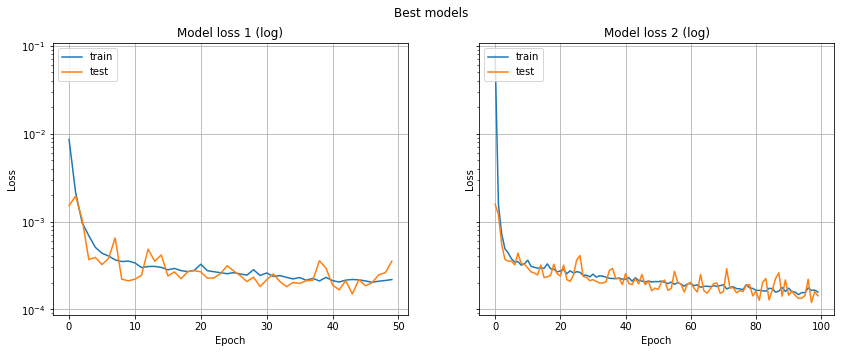

In [192]:
fig, axs = plt.subplots(1, len(models), figsize=(14,5), sharey='row')
fig.suptitle('Best models')
titles = []
for k in range(len(models)):
    titles.append(f"Model loss {k+1} (log)")
    axs[k].plot(histories[k].history['loss'])
    axs[k].plot(histories[k].history['val_loss'])
#     print(titles[-1])
    axs[k].set_title(titles[-1])
    axs[k].set_yscale("log")
    axs[k].legend(['train', 'test'], loc='upper left')
    axs[k].grid()

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Loss')
plt.show()

### Gráficas de comparación

In [135]:
Y_pred1 = models[0].predict(X)
Y_pred2 = models[1].predict(X)

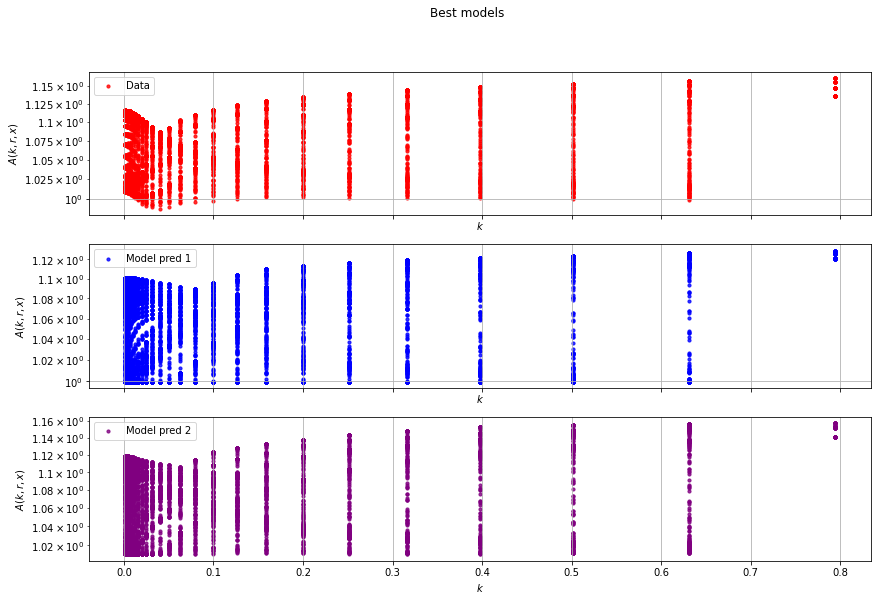

In [172]:
fig, axs = plt.subplots(1+len(models), figsize=(14,9), sharex="col")
fig.suptitle('Best models')

axs[0].scatter(X[:,0], Y, s=1e1, alpha=0.8, c='red', label="Data")
axs[0].set_yscale("log"); axs[0].grid(); axs[0].legend()

axs[1].scatter(X[:,0], Y_pred1, s=1e1, alpha=0.8, c='blue', label="Model pred 1")
axs[1].set_yscale("log"); axs[1].grid(); axs[1].legend()

axs[2].scatter(X[:,0], Y_pred2, s=1e1, alpha=0.8, c='purple', label="Model pred 2")
axs[2].set_yscale("log"); axs[2].grid(); axs[2].legend()

for ax in axs.flat:
    ax.set(xlabel=r'$k$', ylabel='$A(k,r,x)$')
plt.show()

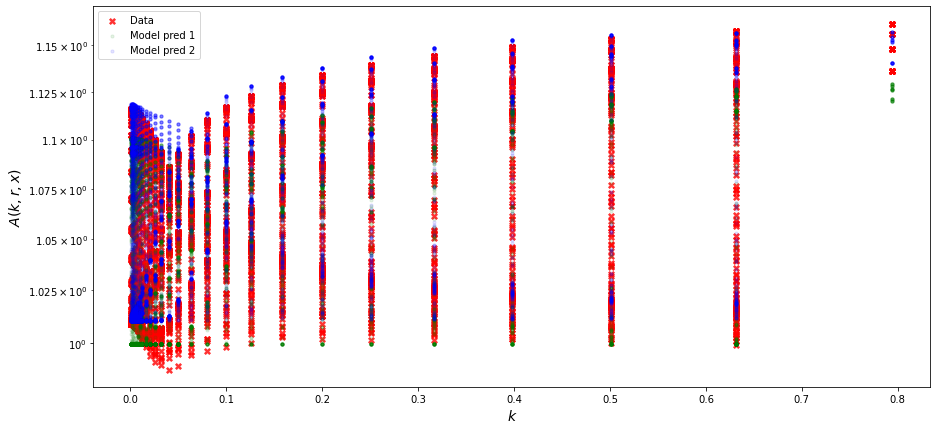

In [155]:
plt.figure(figsize=(15,7))
plt.scatter(X[:,0], Y, s=5e1, alpha=0.8, c='red', label="Data")
plt.scatter(X[:,0], Y_pred1, s=1e1, alpha=0.1, c='green', label="Model pred 1")
plt.scatter(X[:,0], Y_pred2, s=1e1, alpha=0.1, c='blue', label="Model pred 2")
plt.xlabel('$k$', fontsize=14); plt.ylabel(r'$A(k,r,x)$', fontsize=14)
plt.yscale('log'); plt.legend()
plt.show()

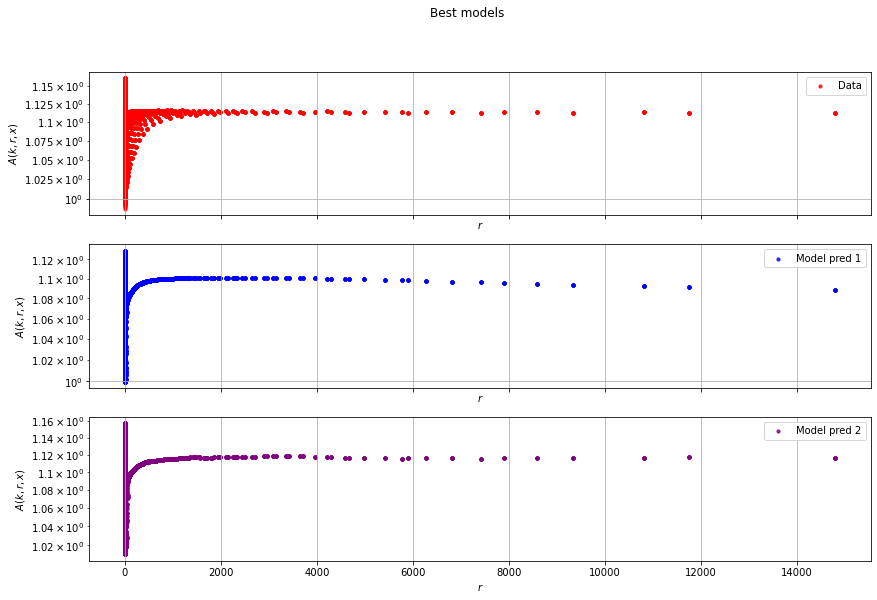

In [173]:
fig, axs = plt.subplots(1+len(models), figsize=(14,9), sharex="col")
fig.suptitle('Data and model predictions')

axs[0].scatter(X[:,1], Y, s=1e1, alpha=0.8, c='red', label="Data")
axs[0].set_yscale("log"); axs[0].grid(); axs[0].legend()

axs[1].scatter(X[:,1], Y_pred1, s=1e1, alpha=0.8, c='blue', label="Model pred 1")
axs[1].set_yscale("log"); axs[1].grid(); axs[1].legend()

axs[2].scatter(X[:,1], Y_pred2, s=1e1, alpha=0.8, c='purple', label="Model pred 2")
axs[2].set_yscale("log"); axs[2].grid(); axs[2].legend()

for ax in axs.flat:
    ax.set(xlabel=r'$r$', ylabel='$A(k,r,x)$')
plt.show()

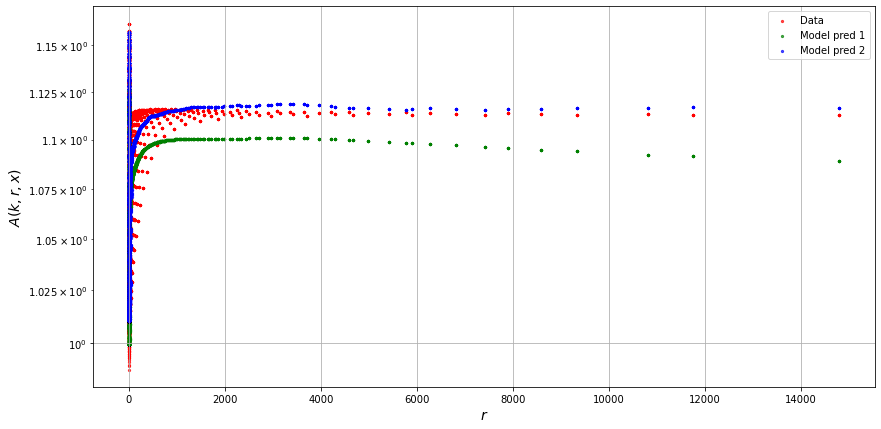

In [179]:
plt.figure(figsize=(14,7))
plt.scatter(X[:,1], Y, s=5e0, alpha=0.7, c='red', label="Data")
plt.scatter(X[:,1], Y_pred1, s=5e0, alpha=0.7, c='green', label="Model pred 1")
plt.scatter(X[:,1], Y_pred2, s=5e0, alpha=0.7, c='blue', label="Model pred 2")
plt.xlabel('$r$', fontsize=14); plt.ylabel(r'$A(k,r,x)$', fontsize=14)
plt.yscale('log'); plt.legend(); plt.grid();
plt.show()

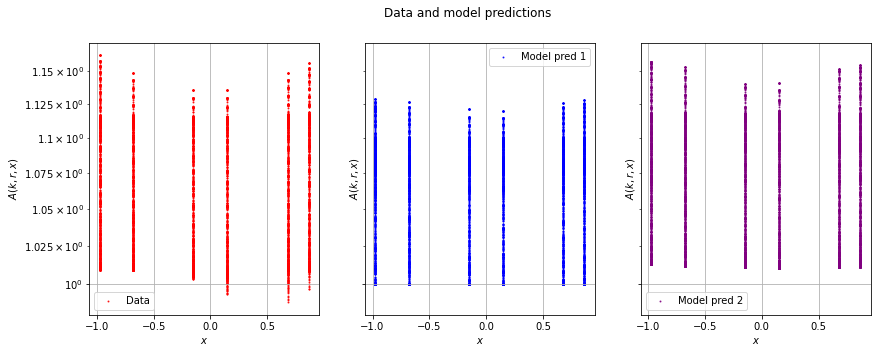

In [187]:
fig, axs = plt.subplots(1,1+len(models), figsize=(14,5), sharey="row")
fig.suptitle('Data and model predictions')

axs[0].scatter(X[:,2], Y, s=1e0, alpha=0.8, c='red', label="Data")
axs[0].set_yscale("log"); axs[0].grid(); axs[0].legend()

axs[1].scatter(X[:,2], Y_pred1, s=1e0, alpha=0.8, c='blue', label="Model pred 1")
axs[1].set_yscale("log"); axs[1].grid(); axs[1].legend()

axs[2].scatter(X[:,2], Y_pred2, s=1e0, alpha=0.8, c='purple', label="Model pred 2")
axs[2].set_yscale("log"); axs[2].grid(); axs[2].legend()

for ax in axs.flat:
    ax.set(xlabel=r'$x$', ylabel='$A(k,r,x)$')
plt.show()

### Comparación 3D

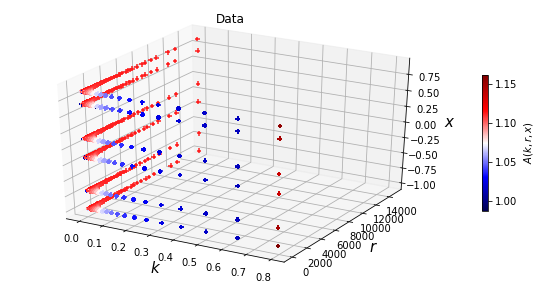

In [189]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X[:,0], X[:,1], X[:,2], marker='+', c=Y, cmap='seismic', alpha=1)
ax.set_xlabel('$k$', fontsize=15)
ax.set_ylabel('$r$', fontsize=15)
ax.set_zlabel('$x$', fontsize=15)
plt.colorbar(p, shrink=0.5, label='$A(k, r, x)$'); plt.title(r"Data")
plt.show()

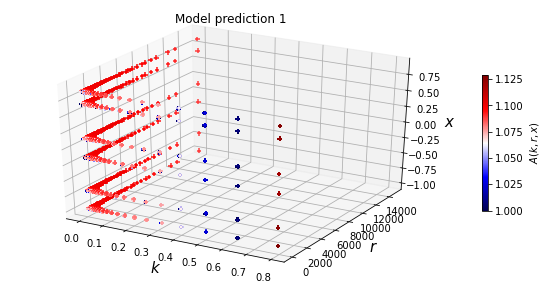

In [190]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X[:,0], X[:,1], X[:,2], marker='+', c=Y_pred1, cmap='seismic', alpha=1)
ax.set_xlabel('$k$', fontsize=15)
ax.set_ylabel('$r$', fontsize=15)
ax.set_zlabel('$x$', fontsize=15)
plt.colorbar(p, shrink=0.5, label='$A(k, r, x)$'); plt.title(r"Model prediction 1")
plt.show()

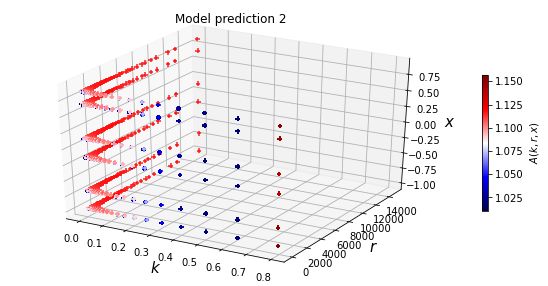

In [191]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X[:,0], X[:,1], X[:,2], marker='+', c=Y_pred2, cmap='seismic', alpha=1)
ax.set_xlabel('$k$', fontsize=15)
ax.set_ylabel('$r$', fontsize=15)
ax.set_zlabel('$x$', fontsize=15)
plt.colorbar(p, shrink=0.5, label='$A(k, r, x)$'); plt.title(r"Model prediction 2")
plt.show()